In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# Data exploration
def load_and_inspect_data(file_path):
    """Load the dataset and perform initial inspection"""
    print("=" * 60)
    print("LOADING AND INSPECTING DATA")
    print("=" * 60)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    print(f"Dataset shape: {df.shape}")
    print(f"\nColumn names and types:")
    print(df.dtypes)
    
    print(f"\nMissing values per column:")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    display(df.head())

    return df


# Check integrity numerical features
def num_features(cols):
    for col in num_cols:
        print(f'Column: {col}')
        negative_values=len(df.loc[df[col]<0])
        print(f'Negative values: {negative_values}')
        


# Model final report
def final_report(y_pred_MODEL):
    print("Accuracy (reduced features):", accuracy_score(y_test, y_pred_MODEL))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_MODEL))
    print("Classification Report:\n", classification_report(y_test, y_pred_MODEL))
    kappa = cohen_kappa_score(y_test, y_pred_MODEL)
    print("Cohen's Kappa:", kappa)




# Model ROC curve
def model_roc_curve(y_true, y_prob, model_name="Model"):
    # Compute ROC-AUC
    roc_auc = roc_auc_score(y_true, y_prob)
    print(f"{model_name} ROC-AUC: {roc_auc:.4f}")

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    # Plot ROC curve
    plt.style.use('ggplot')
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], linestyle='--', color='red', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

In [49]:
file_path='online_shoppers.csv'
df=load_and_inspect_data(file_path)

LOADING AND INSPECTING DATA
Dataset shape: (12330, 18)

Column names and types:
Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Missing values per column:
Series([], dtype: int64)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [50]:
# Clean columns naming

df.columns=df.columns.str.lower()
df.columns=df.columns.str.strip()
df.columns=df.columns.str.replace('_', '')
df.head()

,administrative,administrativeduration,informational,informationalduration,productrelated,productrelatedduration,bouncerates,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend,revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [51]:
mapper={
    'administrative':'admin',
    'administrativeduration':'adminDur',
    'informational': 'info',
    'informationalduration':'infoDur',
    'productrelated':'prodRel',
    'productrelatedduration':'prodRelDur',
    'operatingsystems':'operatingSys',
    'traffictype':'trafficType',
    'visitortype':'visitType'
}
df.rename(columns=mapper, inplace=True)

In [52]:
# Check integrity numerical features

num_cols=['adminDur', 'infoDur', 'prodRelDur', 'bouncerates', 'exitrates', 'pagevalues']
num_features(num_cols)

Column: adminDur
Negative values: 0
Column: infoDur
Negative values: 0
Column: prodRelDur
Negative values: 0
Column: bouncerates
Negative values: 0
Column: exitrates
Negative values: 0
Column: pagevalues
Negative values: 0


In [53]:
df['visitType'].value_counts()

visitType
Returning_Visitor    10527
New_Visitor           1660
Other                   85
new                     23
Returning               14
New                     11
returning                5
ret                      5
Name: count, dtype: int64

In [54]:
month_mapping={
    'Returning_Visitor': 'Returning',
    'Returning': 'Returning',
    'returning': 'Returning',
    'ret': 'Returning',
    'New_Visitor' : 'New',
    'new' : 'New',
    'New' : 'New',
    'Other' : 'Other'
}

In [55]:
df['visitType'] = df['visitType'].map(month_mapping)

In [56]:
df.isna().sum()

admin           0
adminDur        0
info            0
infoDur         0
prodRel         0
prodRelDur      0
bouncerates     0
exitrates       0
pagevalues      0
specialday      0
month           0
operatingSys    0
browser         0
region          0
trafficType     0
visitType       0
weekend         0
revenue         0
dtype: int64

In [8]:
df=df.loc[df['visitType']!='Other']

In [9]:
df.duplicated().sum()

np.int64(121)

In [10]:
df.drop_duplicates(inplace=True)

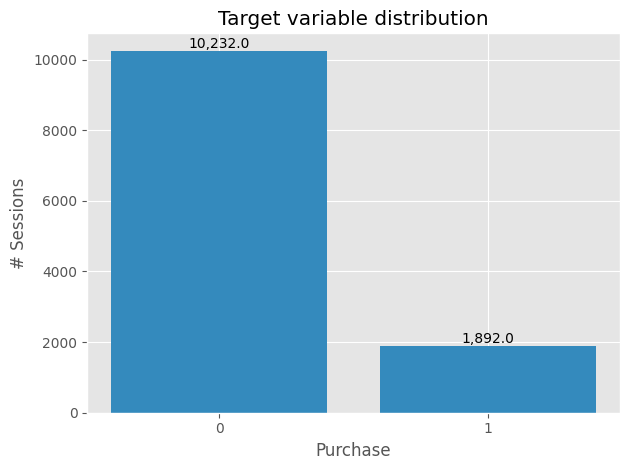

In [12]:
# Label distribution

plt.style.use('ggplot')

x=df['revenue'].value_counts().index
y=df['revenue'].value_counts().values

plt.bar(x, y)
bars = plt.bar(x, y)
plt.bar_label(bars, fmt='{:,}')
plt.title('Target variable distribution')
plt.xticks([0, 1])
plt.xlabel('Purchase')
plt.ylabel('# Sessions')

plt.tight_layout()
plt.show()

In [15]:
# Split into train/test BEFORE feature importance

X=df.drop(columns=['revenue'])
y=df['revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [16]:
# Set function to One-Hot encode X_train

def encoding(df, cols):
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(df[cols])
    encoded_cols = encoder.get_feature_names_out(df[cols].columns)
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    print("\nOne-Hot Encoded DataFrame:")
    print(encoded_df)
    return encoded_df

In [17]:
# One-hot encoding X_train

cols= ['month', 'visitType']
encoded_df=encoding(X_train, cols)

X_train.drop(columns=cols, inplace=True)
X_train = pd.concat([X_train, encoded_df], axis=1)


One-Hot Encoded DataFrame:
       month_Dec  month_Mar  month_May  month_Nov  visitType_New_Visitor  \
8815         1.0        0.0        0.0        0.0                    0.0   
9368         0.0        0.0        0.0        1.0                    0.0   
8459         1.0        0.0        0.0        0.0                    0.0   
4089         0.0        0.0        1.0        0.0                    0.0   
9936         0.0        0.0        0.0        1.0                    0.0   
...          ...        ...        ...        ...                    ...   
777          0.0        1.0        0.0        0.0                    0.0   
9941         0.0        0.0        0.0        1.0                    0.0   
1010         0.0        1.0        0.0        0.0                    0.0   
10902        1.0        0.0        0.0        0.0                    1.0   
11438        0.0        0.0        0.0        1.0                    0.0   

       visitType_Returning_Visitor  
8815                  

In [18]:
# Replace NaN

X_train = X_train.fillna(0)

In [19]:
# One-hot encoding X_test

encoded_df=encoding(X_test, cols)

X_test.drop(columns=cols, inplace=True)
X_test = pd.concat([X_test, encoded_df], axis=1)


One-Hot Encoded DataFrame:
       month_Dec  month_Mar  month_May  month_Nov  visitType_New_Visitor  \
3536         0.0        0.0        1.0        0.0                    0.0   
5288         0.0        0.0        1.0        0.0                    0.0   
10607        0.0        0.0        0.0        1.0                    0.0   
2463         0.0        0.0        1.0        0.0                    0.0   
4223         0.0        0.0        1.0        0.0                    0.0   
...          ...        ...        ...        ...                    ...   
10039        1.0        0.0        0.0        0.0                    0.0   
1115         0.0        1.0        0.0        0.0                    0.0   
1228         0.0        1.0        0.0        0.0                    0.0   
4845         0.0        0.0        1.0        0.0                    0.0   
11644        0.0        0.0        0.0        1.0                    0.0   

       visitType_Returning_Visitor  
3536                  

In [20]:
X_test = X_test.fillna(0)

In [21]:
# Apply SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_train_res))

Resampled class distribution: Counter({False: 6623, True: 6623})


In [22]:
# # Apply SMOTE on test set
# smote = SMOTE(random_state=42)
# X_test_res, y_test_res = smote.fit_resample(X_test, y_test)

# print("Resampled class distribution:", Counter(y_test_res))

In [23]:
# Train model on SMOTEd training data

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_res, y_train_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Cross-validation with all features

scores_full = cross_val_score(clf, X_train_res, y_train_res, cv=5, scoring="accuracy")
print("CV Accuracy (all features):", scores_full.mean())

CV Accuracy (all features): 0.9288185644992414


In [25]:
# Get feature importances (calculated only on training data)
importances = pd.Series(clf.feature_importances_, index=X_train_res.columns)

# Sort for readability
importances = importances.sort_values(ascending=False)

print("Top 10 important features:\n")
print(importances.head(10))

Top 10 important features:

pagevalues                     0.426257
month_Nov                      0.072333
exitrates                      0.071079
prodRelDur                     0.063168
prodRel                        0.052095
bouncerates                    0.036981
month_May                      0.035684
adminDur                       0.034958
visitType_New_Visitor          0.026480
visitType_Returning_Visitor    0.024788
dtype: float64


In [26]:
# Retrain model excluding features

selector = SelectFromModel(clf, threshold='median', prefit=True)
X_train_sel = selector.transform(X_train_res)
X_test_sel = selector.transform(X_test)

# Boolean mask of selected features
selected_mask = selector.get_support()

# Feature names corresponding to selected columns
selected_features = X_train_res.columns[selected_mask]

# Wrap back into DataFrame
X_train_sel = pd.DataFrame(X_train_sel, columns=selected_features, index=X_train_res.index)
X_test_sel = pd.DataFrame(X_test, columns=selected_features, index=X_test.index)


print("Selected features:")
print(selected_features)

print("Reduced feature set shape:", X_train_sel.shape)

# Cross-validation performance with reduced features ----
scores_selected = cross_val_score(clf, X_train_sel, y_train_res, cv=5, scoring="accuracy")
print("CV Accuracy (reduced features):", scores_selected.mean())

Selected features:
Index(['adminDur', 'prodRel', 'prodRelDur', 'bouncerates', 'exitrates',
       'pagevalues', 'month_Dec', 'month_May', 'month_Nov',
       'visitType_New_Visitor', 'visitType_Returning_Visitor'],
      dtype='object')
Reduced feature set shape: (13246, 11)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


CV Accuracy (reduced features): 0.933043241664708


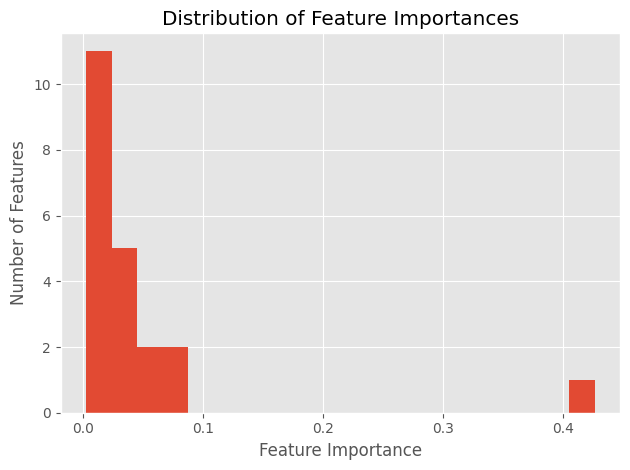

In [27]:
plt.style.use('ggplot')

importances = clf.feature_importances_
plt.hist(importances, bins=20)

plt.title("Distribution of Feature Importances")
plt.xlabel("Feature Importance")
plt.ylabel("Number of Features")
plt.tight_layout()
plt.show()

In [28]:
# Retrain model only with selected features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_sel, y_train_res)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# Make predictions

y_pred_rf = rf.predict(X_test_sel)

In [30]:
final_report(y_pred_rf)

Accuracy (reduced features): 0.8969387755102041
Confusion Matrix:
 [[1548  109]
 [  93  210]]
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.93      0.94      1657
        True       0.66      0.69      0.68       303

    accuracy                           0.90      1960
   macro avg       0.80      0.81      0.81      1960
weighted avg       0.90      0.90      0.90      1960

Cohen's Kappa: 0.6140400816528662


Random Forest ROC-AUC: 0.9278


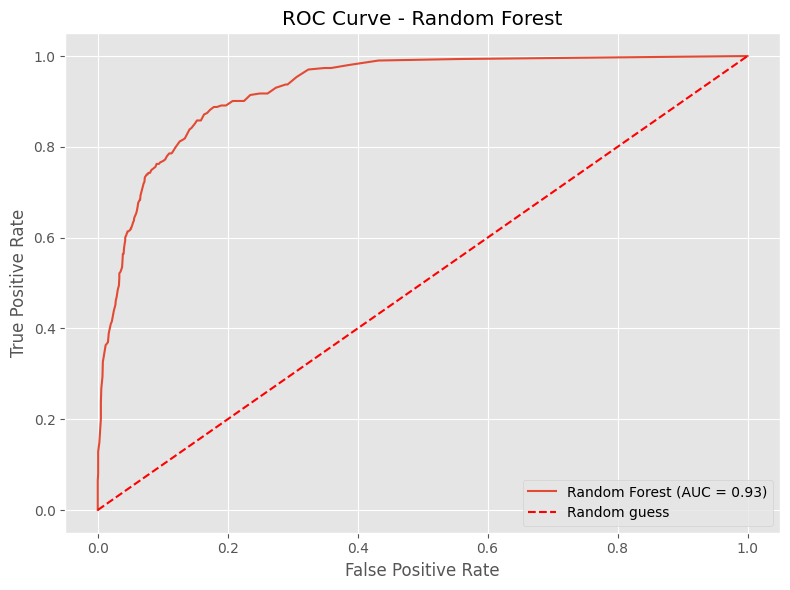

In [31]:
y_prob_rf = rf.predict_proba(X_test_sel)[:, 1]
model_roc_curve(y_test, y_prob_rf, "Random Forest")

In [32]:
selected_features

Index(['adminDur', 'prodRel', 'prodRelDur', 'bouncerates', 'exitrates',
       'pagevalues', 'month_Dec', 'month_May', 'month_Nov',
       'visitType_New_Visitor', 'visitType_Returning_Visitor'],
      dtype='object')

In [33]:
# Scaling numerical features
scaler = StandardScaler()

numeric_cols=['adminDur', 'prodRelDur', 'bouncerates',
       'exitrates', 'pagevalues']

# Fit on training numeric features
X_train_sel[numeric_cols] = scaler.fit_transform(X_train_sel[numeric_cols])

# Transform test set numeric features
X_test_sel[numeric_cols] = scaler.transform(X_test_sel[numeric_cols])

In [34]:
logReg = LogisticRegression(solver='liblinear', random_state=42)
logReg.fit(X_train_sel, y_train_res)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [35]:
# Make predictions

y_pred_lr = logReg.predict(X_test_sel)

In [36]:
final_report(y_pred_lr)

Accuracy (reduced features): 0.8704081632653061
Confusion Matrix:
 [[1469  188]
 [  66  237]]
Classification Report:
               precision    recall  f1-score   support

       False       0.96      0.89      0.92      1657
        True       0.56      0.78      0.65       303

    accuracy                           0.87      1960
   macro avg       0.76      0.83      0.79      1960
weighted avg       0.90      0.87      0.88      1960

Cohen's Kappa: 0.5742519220408269


Linear Regression ROC-AUC: 0.9168


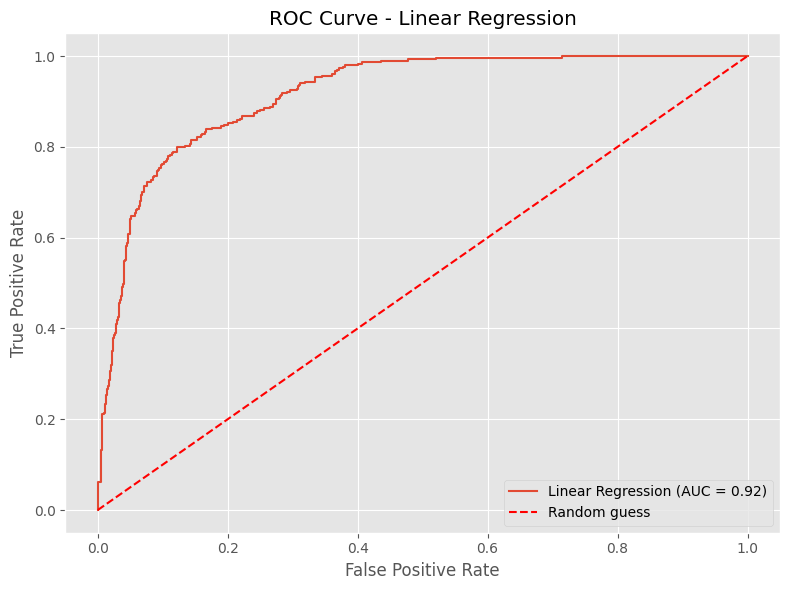

In [37]:
y_prob_lr = logReg.predict_proba(X_test_sel)[:, 1]
model_roc_curve(y_test, y_prob_lr, "Linear Regression")